# Kaggle Digit Recognizer Competition - MNIST Image classification using fastai libraries

## Model accuracy = 99.37% (Resnet34 with updated LR)

### Data gathered - https://www.kaggle.com/scolianni/mnistasjpg

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
import glob

## Looking at the training data

### list of classes we have

In [4]:
path = Path('/home/ubuntu/MNIST/')

In [3]:
classes = ['0','1','2','3','4','5','6','7','8','9']

In [6]:
for c in classes:
    print(c)
    verify_images(path/'train'/c, delete=True, max_size=500)

0


1


2


3


4


5


6


7


8


9


## view data

In [7]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train='train', valid_pct=0.2,
        ds_tfms=get_transforms(do_flip=False), size=224, num_workers=4).normalize(imagenet_stats)

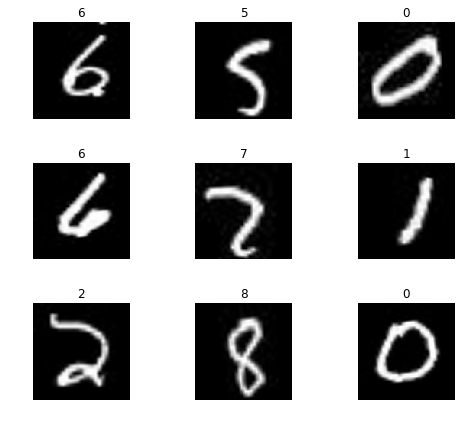

In [8]:
data.show_batch(rows=3, figsize=(7,6))

In [9]:
print(data.classes)
len(data.classes),data.c

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


(10, 10)

## Training: resnet34

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [11]:
# learn.model

In [26]:
learn.fit_one_cycle(4)

In [13]:
learn.save('stage-1')

## Results

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

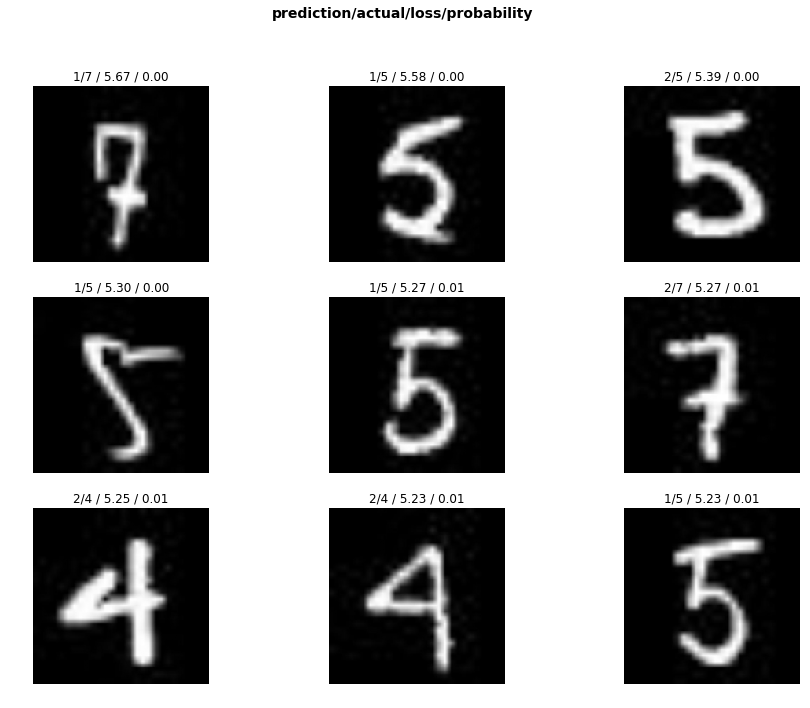

In [15]:
interp.plot_top_losses(9, figsize=(15,11), heatmap = False)

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### most confused categories and how many times

In [17]:
interp.most_confused(min_val=2)

[('5', '3', 7),
 ('0', '6', 4),
 ('3', '5', 4),
 ('4', '9', 4),
 ('9', '4', 4),
 ('9', '7', 4),
 ('2', '3', 3),
 ('3', '2', 3),
 ('7', '2', 3),
 ('7', '4', 3),
 ('8', '4', 3),
 ('0', '2', 2),
 ('1', '2', 2),
 ('2', '1', 2),
 ('2', '9', 2),
 ('3', '9', 2),
 ('5', '6', 2),
 ('6', '5', 2),
 ('8', '0', 2),
 ('8', '3', 2),
 ('8', '5', 2),
 ('8', '9', 2)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [18]:
learn.unfreeze()

In [19]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.035644,0.012021,0.004167,06:56


In [13]:
learn.save('stage-1-1')

### loading the previously saved model to find suitable learning rate

In [20]:
learn.load('stage-1');

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


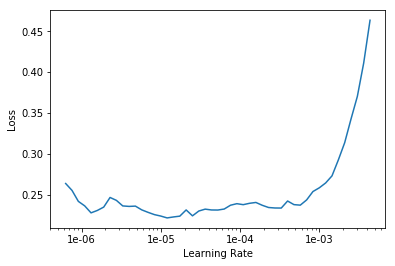

In [33]:
learn.recorder.plot()

### training the model using updated LR based on above plot

In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(5e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.049142,0.023642,0.007976,06:47
1,0.025244,0.015466,0.004881,06:48


In [23]:
learn.save('stage-2')

That's a pretty accurate model!

## Trying another model

## Training: resnet50

In [25]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [26]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.198908,0.083484,0.025357,09:49
1,0.098401,0.041495,0.012024,09:43
2,0.062866,0.031928,0.010952,09:41
3,0.040867,0.020694,0.006786,09:43
4,0.026009,0.020058,0.007024,09:42


In [29]:
learn.save('stage-3')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


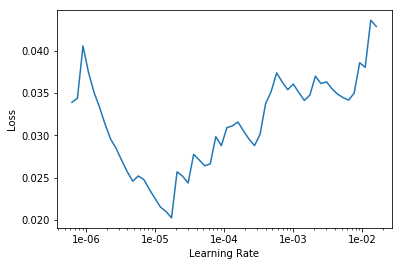

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.031214,0.019876,0.006786,12:40
1,0.025841,0.018966,0.005952,12:39
2,0.022954,0.017306,0.005714,12:39
3,0.024590,0.018158,0.005833,12:39
4,0.022098,0.017491,0.006071,12:39


In [32]:
learn.save('stage-4')

### If it doesn't look good, you can always go back to your previous model. In our case, `stage-2` model turned out to be a better model

In [34]:
learn = cnn_learner(data, models.resnet34)

In [35]:
learn.load('stage-2');

In [36]:
interp = ClassificationInterpretation.from_learner(learn)

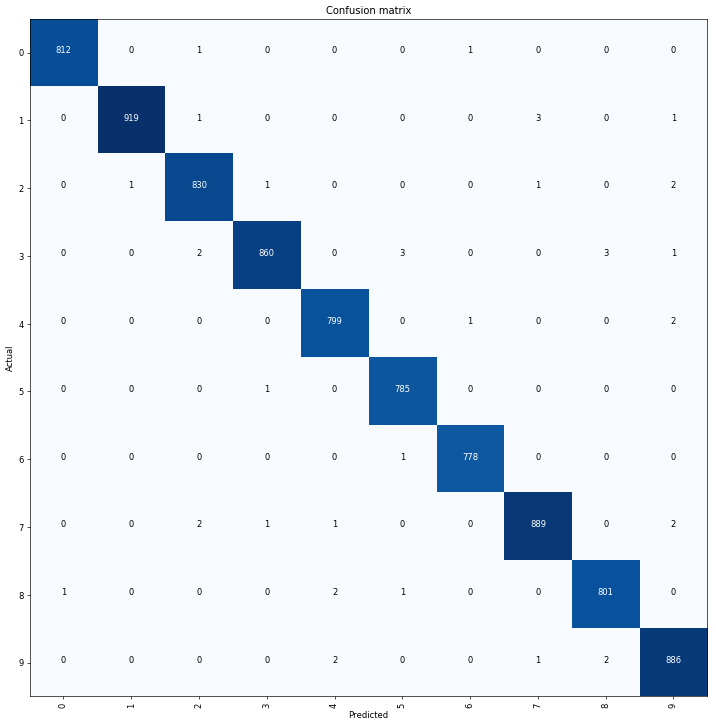

In [39]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### when you have many class values, then confusion matrix might not be a good way to see what went wrong, so in such cases, below mentioned function, `most_confused` can be used to understand what went wrong

actual class, predicted class, how many times

In [40]:
interp.most_confused(min_val=2)

[('1', '7', 3),
 ('3', '5', 3),
 ('3', '8', 3),
 ('2', '9', 2),
 ('3', '2', 2),
 ('4', '9', 2),
 ('7', '2', 2),
 ('7', '9', 2),
 ('8', '4', 2),
 ('9', '4', 2),
 ('9', '8', 2)]

## test data predictions

using `stage2` model for predictions

Will be predicted 1 image at a time using `single_from_classes` -- Every image in the train data will be transformed in the same way that we used to transform the train images

In [5]:
data2 = ImageDataBunch.single_from_classes(path, classes, 
                                  ds_tfms=get_transforms(do_flip=False), size=224).normalize(imagenet_stats)

In [6]:
learn = cnn_learner(data2, models.resnet34)
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/ubuntu/MNIST;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /home/ubuntu/MNIST;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (

### check sample prediction

In [20]:
img = open_image(path/'test'/'img_2.jpg')
img

In [21]:
pred_class, pred_idx, outputs = learn.predict(open_image(path/'test'/'img_2.jpg'))
pred_class

Category 0

### original value was `0` and predicted value was also `0`

Model is working properly, now apply it to the whole training data

In [10]:
test_values = []
for i in range(1,28001,1):
    test_values.append(glob.glob("/home/ubuntu/MNIST/test/img_"+str(i)+".jpg"))

flat_list = [item for sublist in test_values for item in sublist]

### actual predictions

In [16]:
%%time
preds = []
for img in flat_list:
    pred_class, pred_idx, outputs = learn.predict(open_image(img))
    preds.append(pred_class)

CPU times: user 30min 44s, sys: 1min 56s, total: 32min 40s
Wall time: 8min 12s


In [22]:
num = list(range(1,28001))

In [23]:
df_preds = pd.DataFrame({'ImageId': num, 'Label': preds})

In [24]:
df_preds.Label.value_counts()

1    3186
7    2888
2    2823
3    2792
9    2777
0    2775
8    2754
4    2746
6    2728
5    2531
Name: Label, dtype: int64

In [25]:
df_preds.to_csv(path/'predictions.csv', index=False)